# Create metapaths for analysis

In [1]:
import json
import collections
import math
import configparser

import numpy
import pandas

import hetio.readwrite
import neo4j

In [2]:
# Load metagraph for the hetnet
metagraph = hetio.readwrite.read_metagraph('basenodes_metagraph.json')

## Construct list of metapaths

In [3]:
def remove(metapath):
    """
    Return True if metpath should be removed, so features
    are not computed for it.
    """
    if len(metapath) == 1:
        return True
    return False

In [4]:
metapaths = metagraph.extract_metapaths('Compound', 'Disease', max_length=4)
metapaths.sort(key=lambda x: (len(x), str(x)))

obj = collections.OrderedDict()
removed = list()
for metapath in metapaths:
    if remove(metapath):
        removed.append(metapath)
        continue
    item = collections.OrderedDict()
    item['length'] = len(metapath)
    item['abbreviation'] = str(metapath)
    item['edges'] = [str(x) for x in metapath.edges]
    item['standard_edges'] = [str(x.inverse if x.inverted else x) for x in metapath.edges]
    item['edge_abbreviations'] = [x.get_abbrev() for x in metapath.edges]
    item['standard_edge_abbreviations'] = [x.get_standard_abbrev() for x in metapath.edges]
    obj[metapath] = item

print('Removed {} metapaths'.format(len(removed)))

Removed 1 metapaths


## Estimate metapath complexity by join index

In [5]:
path = '../degrees.xlsx'
degree_dfs = dict()
for metanode in metagraph.get_nodes():
    metanode_name = str(metanode)
    degree_dfs[metanode_name] = pandas.read_excel(path, sheetname=metanode_name)

In [6]:
metaedge_to_degree = dict()
for degree_df in degree_dfs.values():
    degrees = degree_df.iloc[:, 2:].apply(lambda x: numpy.average(x), axis='rows')
    for metaedge, degree in degrees.items():
        metaedge_to_degree[metaedge] = degree

In [7]:
def get_join_complexities(forward, backward):
    """
    Returns a log10 measure of the estimated computational complexity for
    joining at each node along a path. `forward` and `backward` are
    estiamted degrees of the source node for each edge in a path.
    `backward` traverses the path from left to right.
    """
    assert len(forward) == len(backward)
    complexities = list()
    for i in range(len(forward) + 1):
        head = numpy.prod(forward[:i] or 0)
        tail = numpy.prod(backward[i:] or 0)
        complexities.append(math.log10(head + tail))
    return complexities

In [8]:
for metapath, item in obj.items():
    forward = list()
    backward = list()
    for metaedge in metapath:
        forward.append(metaedge_to_degree[str(metaedge)])
        backward.append(metaedge_to_degree[str(metaedge.inverse)])
    complexities = get_join_complexities(forward, backward)
    # item['forward_degrees'] = forward
    # item['backward_degrees'] = backward
    item['join_complexities'] = complexities
    item['optimal_join_index'] = int(numpy.argmin(complexities))
    item['midpoint_index'] = len(metapath) // 2

In [9]:
# Percent of time the complexity join index is the midpoint
numpy.mean([item['midpoint_index'] == item['optimal_join_index'] for item in obj.values()])

0.0

## Create Cypher query

In [10]:
# Cypher DWPC query parameters
dwpc_query_options = {
    'property': 'identifier',
    'index_hint': False,
    'unique_nodes': 'labeled',
}

In [11]:
x = list(obj.keys())[0]

In [12]:
for metapath, item in obj.items():
    opts = dwpc_query_options.copy()
    opts['join_hint'] = item['midpoint_index']
    item['dwpc_query'] = neo4j.construct_dwpc_query(metapath, **opts)

## Save metapaths as a JSON file 

In [13]:
path = 'data/metapaths.json'
with open(path, 'w') as fp:
    json.dump(list(obj.values()), fp, indent=2)

path = 'data/metaedge-to-mean-degrees.json'
with open(path, 'w') as fp:
    json.dump(metaedge_to_degree, fp, indent=2, sort_keys=True)

## Metapaths as a DataFrame

In [14]:
metapath_df = pandas.DataFrame(list(obj.values()))
metapath_df['sequential_complexity'] = metapath_df.join_complexities.map(lambda x: x[0])
metapath_df = metapath_df[['abbreviation', 'length', 'midpoint_index', 'optimal_join_index', 'sequential_complexity']]
metapath_df.head(2)

,abbreviation,length,midpoint_index,optimal_join_index,sequential_complexity
0,C<hpCduftD,2,1,0,-0.709247
1,C<ioCduftD,2,1,0,-2.116976


In [15]:
metapath_df.to_csv('data/metapaths.tsv', index=False, sep='\t')

In [16]:
%matplotlib inline
import seaborn

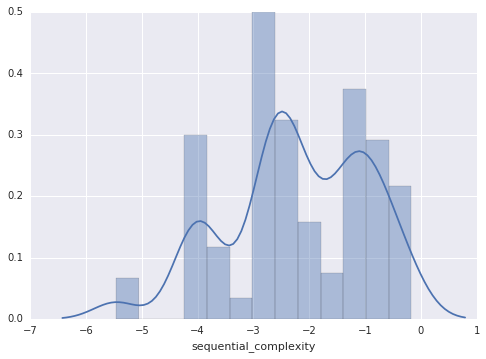

In [17]:
ax = seaborn.distplot(metapath_df.sequential_complexity)

## Metaedges in each metapath

In [18]:
rows = list()
for metapath in obj.keys():
    for i, edge in enumerate(metapath.edges):
        edge = edge.inverse if edge.inverted else edge
        rows.append((str(metapath), str(edge), edge.get_standard_abbrev(), i + 1, len(metapath)))
metaedge_df = pandas.DataFrame(rows, columns=['metapath', 'metaedge', 'metaedge_abbrev', 'position', 'length'])
metaedge_df.to_csv('data/metaedge-in-metapath.tsv', sep='\t', index=False)
metaedge_df.head(2)

,metapath,metaedge,metaedge_abbrev,position,length
0,C<hpCduftD,Compound > has-part > Compound,ChpC,1,2
1,C<hpCduftD,Disease - drug-used-for-treatment - Compound,DduftC,2,2
